In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc
from sklearn.model_selection import train_test_split
from scripts.proj1_helpers import create_csv_submission, load_csv_data

seed = 9
np.random.seed(seed)

# Preprocessing

### The very first step in every data science pipeleine is loading the date and spliting on the train/val/test holdouts

In [2]:
with open("data/test.csv", "r") as f:
    columns = f.readline().split(",")[2:]

y_test, X_test, ids_test = load_csv_data('data/test.csv')
y_dev, X_dev, ids_dev = load_csv_data('data/train.csv')

### We will split `dev` dataset on train and validation datasets with ratio 80 : 20 respectively

In [3]:
ratio = 0.8
num_row = X_dev.shape[0]
indices = np.random.permutation(num_row)
    
index_split = int(np.floor(ratio * num_row))
index_train = indices[: index_split]
index_val = indices[index_split:]

# split
y_train, X_train, ids_train = y_dev[index_train], X_dev[index_train], ids_dev[index_train]
y_val, X_val, ids_val = y_dev[index_val], X_dev[index_val], ids_dev[index_val]

### Next we will plot the distributions of features of dataset

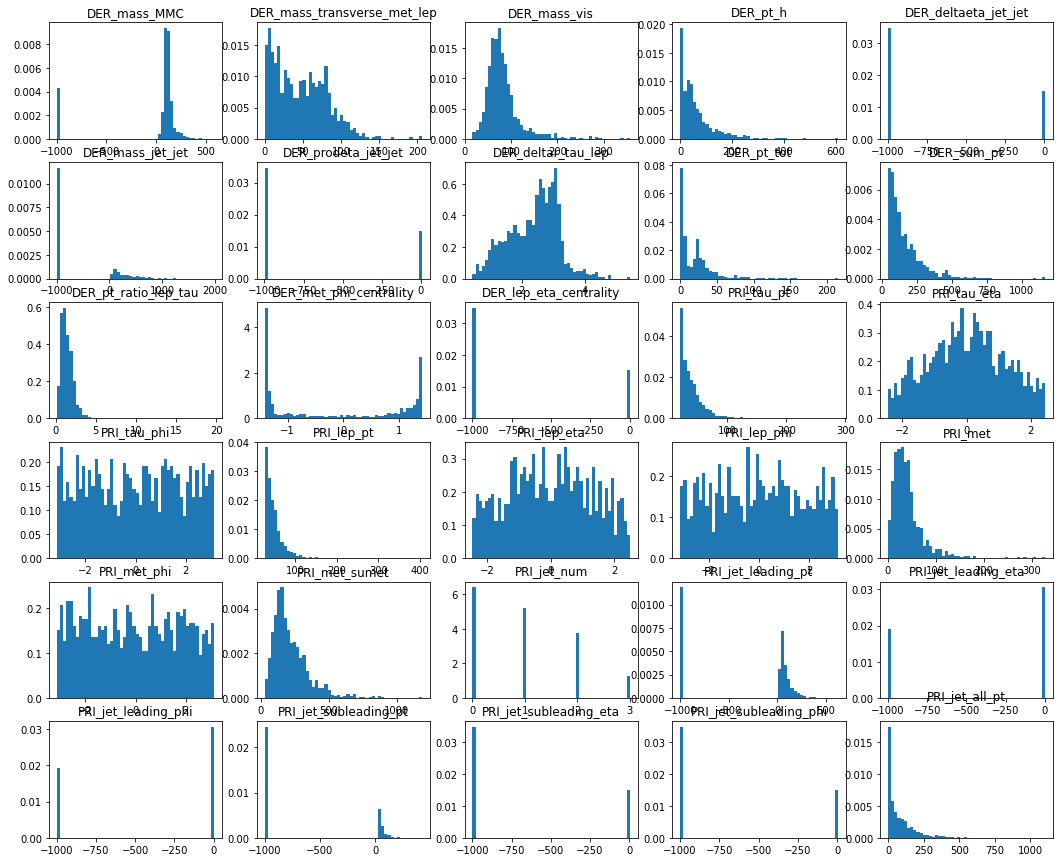

In [4]:
fig, axs = plt.subplots(6, 5, figsize=(18,15))
for i in range(X_train.shape[1]):
    ax = axs[i // 5, i % 5]
    ax.hist(
        X_train[:1000, i],
        bins=50, 
        density=True, 
    )
    ax.set_title(columns[i])

### As we can see there are several features, containg a lot of -1000 vaules. This values can be interpret as outliners, and in this regard we will replace tham with average value of the coresponding feature

In [5]:
for i in range(X_train.shape[1]):
    features = X_train[:, i]
    mean = features[features >= -998.0].mean()
    X_train[:, i] = np.where(X_train[:, i] < -990.0, mean, X_train[:, i])
    X_val[:, i] = np.where(X_val[:, i] < -990.0, mean, X_val[:, i])
    X_test[:, i] = np.where(X_test[:, i] < -990.0, mean, X_test[:, i])

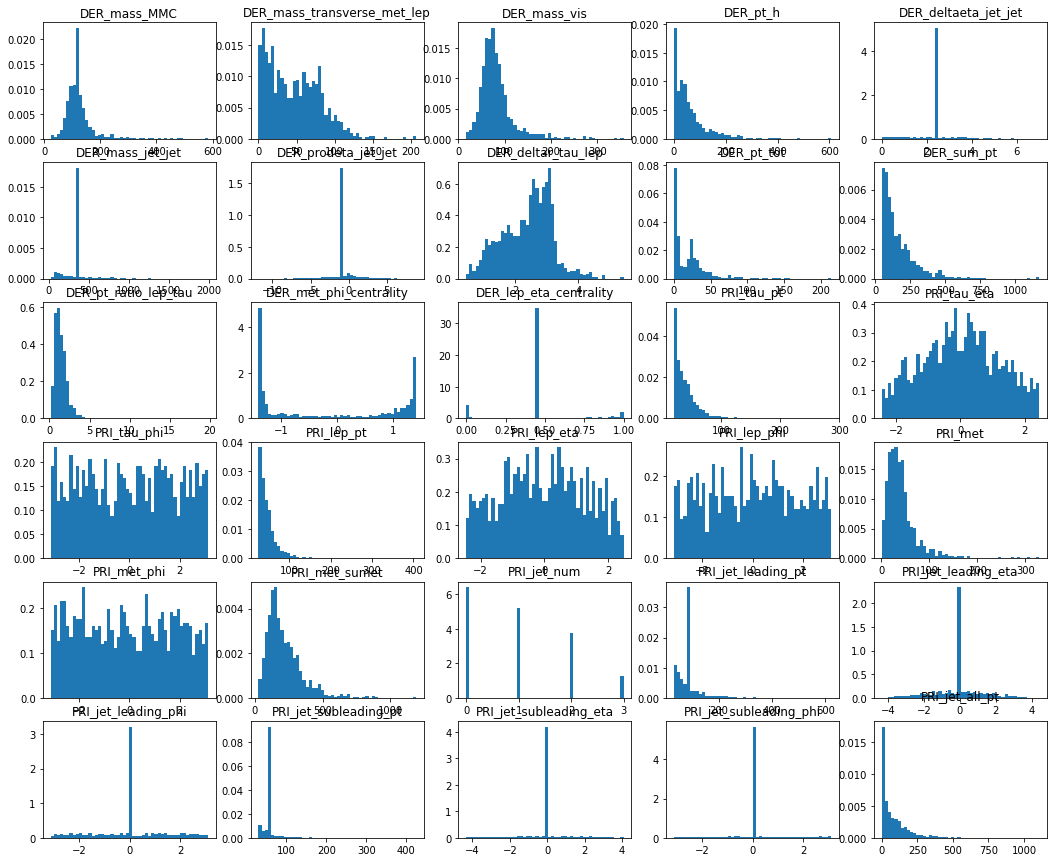

In [6]:
fig, axs = plt.subplots(6, 5, figsize=(18,15))
for i in range(X_train.shape[1]):
    ax = axs[i // 5, i % 5]
    ax.hist(
        X_train[:1000, i],
        bins=50, 
        density=True, 
    )
    ax.set_title(columns[i])

### Now all the outliers are replaced with mean values. Next we will build a correlation matrix of the features to understed whether we have a correlated features

<AxesSubplot:>

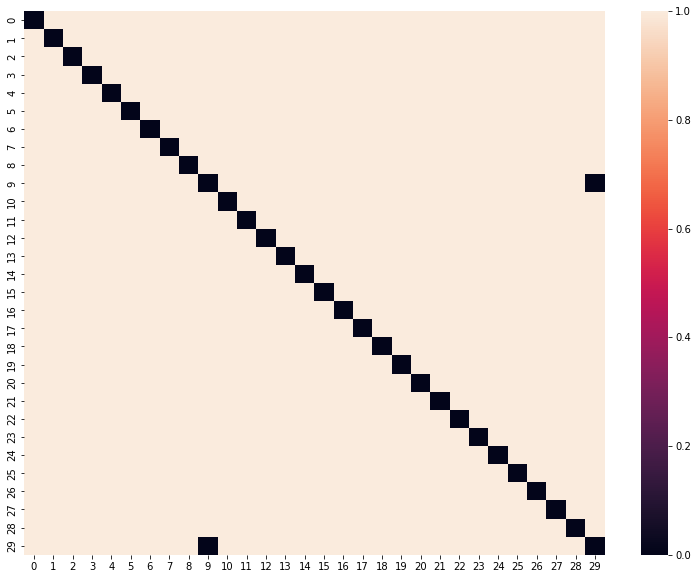

In [7]:
X_train_normalized = X_train / np.linalg.norm(X_train, axis=0)
corr_matrix = np.corrcoef(X_train_normalized.T)
plt.figure(figsize=(13, 10))
sns.heatmap((corr_matrix < 0.95) & (-0.95 < corr_matrix))

### Here we can see that there are only few highly correlated features. We will basically drop tham

In [8]:
cor_features_ids = [pair for pair in np.argwhere((corr_matrix >= 0.95) | (-0.95 >= corr_matrix)) if pair[0] != pair[1]][::2]

In [9]:
ids_to_delete = [pair[0] for pair in cor_features_ids]
X_train = np.delete(X_train, ids_to_delete, axis=1)
X_val = np.delete(X_val, ids_to_delete, axis=1)
X_test = np.delete(X_test, ids_to_delete, axis=1)

### Since we plan to use the logistic regression method lets chack how feature correlates with taget

<AxesSubplot:>

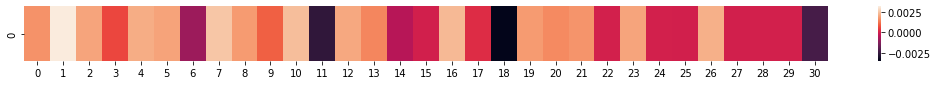

In [10]:
y_train_normalized = y_train / np.linalg.norm(y_train)
features = np.concatenate([X_train_normalized, y_train_normalized.reshape(-1, 1)], axis=-1)
corr_matrix = np.corrcoef(features.T)
plt.figure(figsize=(18, 1))
sns.heatmap(features[0, :].reshape(1, -1))

### Next we will transform features usin log transfromation to obtain features more correlated with the target

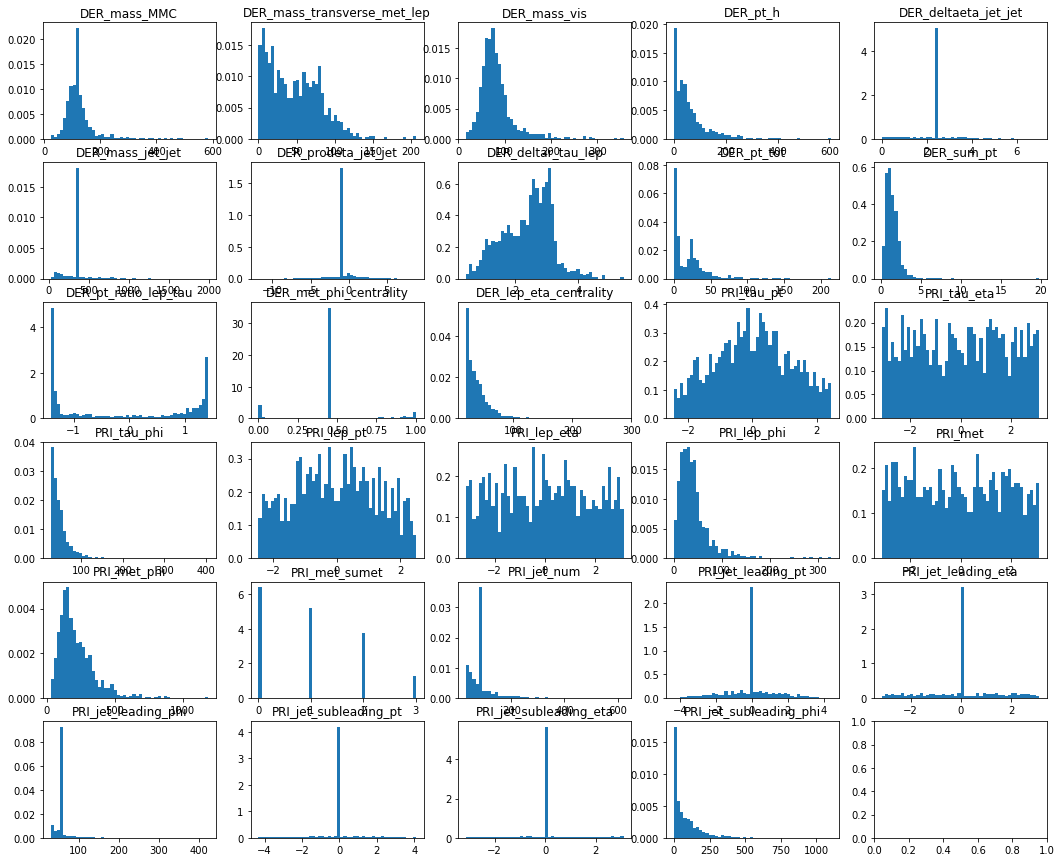

In [11]:
fig, axs = plt.subplots(6, 5, figsize=(18,15))
for i in range(X_train.shape[1]):
    ax = axs[i // 5, i % 5]
    ax.hist(
        X_train[:1000, i],
        bins=50, 
        density=True, 
    )
    ax.set_title(columns[i])

In [12]:
for i in [
    3, 8, 9, 12, 15, 18, 25, 28
]:
    X_train[:, i] = np.log(X_train[:, i] -  X_train[:, i].min() + 0.0001)
    X_val[:, i] = np.log(X_val[:, i] -  X_val[:, i].min() + 0.0001)
    X_test[:, i] = np.log(X_test[:, i] -  X_test[:, i].min() + 0.0001)

<AxesSubplot:>

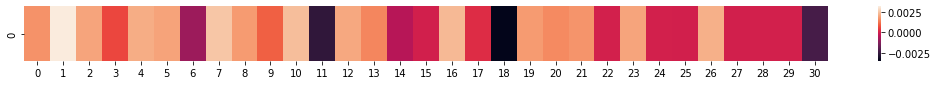

In [13]:
y_train_normalized = y_train / np.linalg.norm(y_train)
features = np.concatenate([X_train_normalized, y_train_normalized.reshape(-1, 1)], axis=-1)
corr_matrix = np.corrcoef(features.T)
plt.figure(figsize=(18, 1))
sns.heatmap(features[0, :].reshape(1, -1))

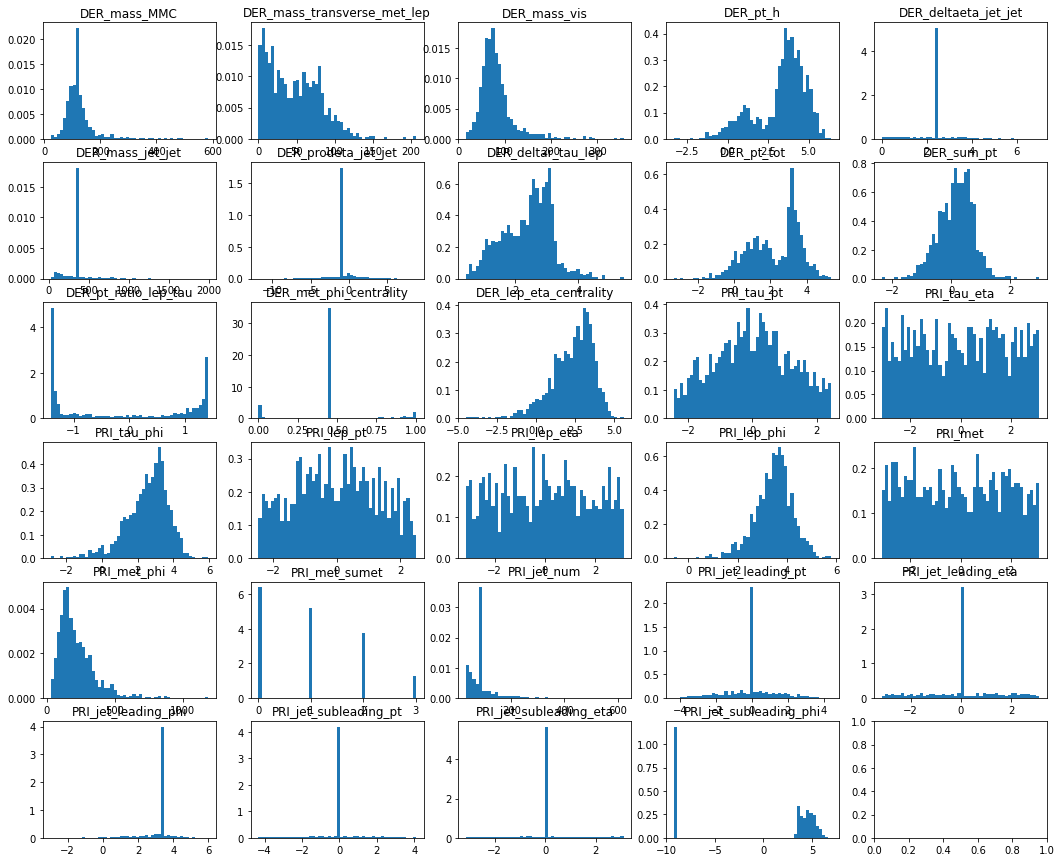

In [14]:
fig, axs = plt.subplots(6, 5, figsize=(18,15))
for i in range(X_train.shape[1]):
    ax = axs[i // 5, i % 5]
    ax.hist(
        X_train[:1000, i],
        bins=50, 
        density=True, 
    )
    ax.set_title(columns[i])

# NEXT CELLS STILL HAVE SOME CODE TO REWRITE

In [ ]:
features_to_cut = [
    'DER_mass_MMC', 'DER_mass_transverse_met_lep',
    'DER_mass_vis', 'DER_pt_h', 'DER_mass_jet_jet', 'DER_deltar_tau_lep',
    'DER_pt_tot', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
    'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta',
    'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet',
    'PRI_jet_leading_pt', 'PRI_jet_subleading_pt',
]

In [ ]:
mask_995 = train_df[features_to_cut].stack().quantile(0.9999)
mask_005 = train_df[features_to_cut].stack().quantile(0.0001)
train_df = train_df.loc[((train_df.loc[:, features_to_cut] < mask_995) & (train_df.loc[:, features_to_cut] > mask_005)).all(axis=1)]

In [ ]:
# One hot encode

train_df = pd.concat([train_df, pd.get_dummies(train_df["PRI_jet_num"], prefix='PRI_jet_num')], axis=1).copy()
del train_df["PRI_jet_num"]
val_df = pd.concat([val_df, pd.get_dummies(val_df["PRI_jet_num"], prefix='PRI_jet_num')], axis=1).copy()
del val_df["PRI_jet_num"]
test_df = pd.concat([test_df, pd.get_dummies(test_df["PRI_jet_num"], prefix='PRI_jet_num')], axis=1).copy()
del test_df["PRI_jet_num"]

In [ ]:
from implementations import ridge_regression

In [ ]:
# Add bias term

X_train, y_train = train_df[X_columns].values, train_df[y_column].values
X_val, y_val = val_df[X_columns].values, val_df[y_column].values
X_train = np.concatenate([X_train, np.ones(X_train.shape[0]).reshape(-1, 1)], axis=1)
X_val = np.concatenate([X_val, np.ones(X_val.shape[0]).reshape(-1, 1)], axis=1)

In [ ]:
w_pure = ridge_regression(y_train, X_train, lambda_=0.)
y_pred = (X_val @ w_pure).reshape(-1, 1)
y_pred = np.concatenate([1 - y_pred, y_pred], axis=1)
plot_roc(y_val, y_pred, figsize=(8,8))

In [ ]:
from scripts.proj1_helpers import create_csv_submission, load_csv_data

In [ ]:
from sklearn.decomposition import PCA
from scikitplot.decomposition import plot_pca_component_variance
pca = PCA(random_state=1)
pca.fit(X)
plot_pca_component_variance(pca, figsize=(12,8))

In [ ]:
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler

pca = PCA(random_state=1)
preproc = StandardScaler()
preproc.fit(X_train)
pca.fit(preproc.transform(X_train))
plot_pca_component_variance(pca, figsize=(12,8), target_explained_variance=0.99)
ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = np.where(ratio == ratio[ratio > 0.99][0])[0][0] + 1

In [ ]:
w_pure = ridge_regression(y_train, X_train, lambda_=0.)
y_pred = (X_val @ w_pure).reshape(-1, 1)
y_pred = np.concatenate([1 - y_pred, y_pred], axis=1)
plot_roc(y_val, y_pred, figsize=(8,8))

In [ ]:
pca = PCA(random_state=1, n_components=2)
preproc = StandardScaler()
preproc.fit(X_train)
pca.fit(preproc.transform(X_train))
X_pca = pca.transform(preproc.transform(X_train))[:100, :]
y_pca = y[:100]

In [ ]:
v2c = {
    1: "red",
    0: "blue"
}

In [ ]:
plt.figure(figsize=(10, 10))
plt.grid()
plt.scatter(X_pca[:,0], X_pca[:,1], c=[v2c[y_] for y_ in y_pca.reshape(-1)])
plt.show()

In [ ]:
def pca(X, n_components: int):
    mean = np.mean(X, axis=0)
    sigma = np.cov(X)
    values, components = np.linalg.eig(V)
    transformed = vectors.T @ X
    return transformed, vectors, values
